<a href="https://colab.research.google.com/github/mikequant/notifinio_backtest/blob/master/Portfolio_backtest_visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Portfolio Visualizer for [Notifinio](https://www.notifinio.com) backtest

---

Possibilities:
*  Get prices for multiple assets
* Monthly or yearly rebalace
* ROI & Max Drawdown charts

# 0. Import libraries and set configuration

---

In [0]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [2]:
!pip install matplotlib

In [3]:
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from functools import partial
import time
import requests
import io
import os.path
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Get  free API here https://www.alphavantage.co/ and paste as AA_API



In [0]:
save_results_path = '/content/gdrive/My Drive'
AA_API = ''

# Download data

In [0]:
def download_or_read(symbol):
    """
    Download data or read from local file.
    Save to file without future updating.
    """
    path = 'symbols'
    if not os.path.isdir(path):
        os.mkdir(path)
    
    filename = f'{path}/{symbol}.csv'
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            return f.read()
    
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api}&datatype=csv&outputsize=full'
    while True:
        r = requests.get(url.format(symbol=symbol, api=AA_API))
        content = r.content.decode('UTF-8')
        if 'premium' in content:
            print('Limit error. Waiting for 60 seconds.')
            time.sleep(60)
        else:
            with open(filename, 'w') as f:
                f.write(content) 
            return content

In [70]:
SYMBOLS = ['SPY','MTUM','VTI','VTV','LQD','BND','AGG','QQQ']

df = None
for s in SYMBOLS:
    data = pd.read_csv(io.StringIO(download_or_read(s)))
    data['symbol'] = s
    if df is None:
        df = data
    else:
        df = pd.concat([df, data])
        
df['dt'] = pd.to_datetime(df['timestamp'])
df = df[['dt', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'adjusted_close']]
print(df.symbol.unique())

['SPY' 'MTUM' 'VTI' 'VTV' 'LQD' 'BND' 'AGG' 'QQQ']


In [71]:
def adjusting(df, is_adjusted):
    # adjusting prices with splits & dividends
    if not is_adjusted:
        ratio = df.adjusted_close / df.close
        df['open'] *= ratio
        df['high'] *= ratio
        df['low'] *= ratio
        df['close'] *= ratio
        df['volume'] = (df['volume'] / ratio).astype(int)
    return True
        
is_adjusted = False
print(df['symbol'].unique())

['SPY' 'MTUM' 'VTI' 'VTV' 'LQD' 'BND' 'AGG' 'QQQ']


In [72]:
is_adjusted = adjusting(df, is_adjusted)  # adjusting for splits & dividends
print('Adjusted: ', df['symbol'].unique())

Adjusted:  ['SPY' 'MTUM' 'VTI' 'VTV' 'LQD' 'BND' 'AGG' 'QQQ']


In [73]:
# show start dates
df.groupby('symbol').dt.min().sort_values()

symbol
QQQ    1999-08-09
SPY    1999-08-09
VTI    2001-06-15
LQD    2002-07-30
AGG    2003-09-29
VTV    2004-01-30
BND    2007-04-10
MTUM   2013-04-18
Name: dt, dtype: datetime64[ns]

# 1. Set index for grouping by ticker and period

In [0]:
df = df.set_index(['dt', 'symbol'], drop=False).sort_index()
df.tail(len(df.index.levels[1]) * 2)
#Export combined source data
df.to_csv(path_or_buf='/content/gdrive/My Drive/$$$/NOTIFIN.IO/Robo/Data/d.csv',index=True)

# 2. Group and show price graphs

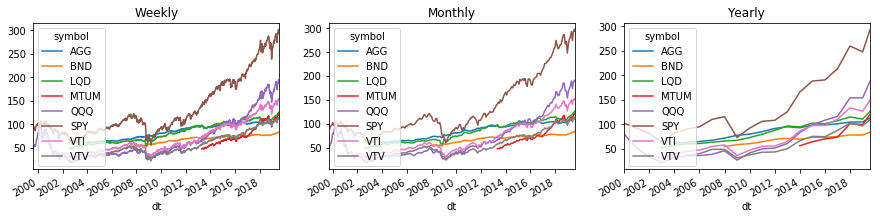

In [75]:
# правила обработки колонок при группировке
agg_rules = {
    'dt': 'last', 'symbol': 'last',
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last',
    'volume': 'sum',
}
fig = plt.figure(figsize=(15, 3), facecolor='white')
level_values = df.index.get_level_values
df.groupby([pd.Grouper(freq='W', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(131), title="Weekly")
df.groupby([pd.Grouper(freq='M', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(132), title="Monthly")
df.groupby([pd.Grouper(freq='Y', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(133), title="Yearly")
plt.show()

#3. Set index with source data

In [76]:
monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules)
monthly.tail(len(df.index.levels[1]))

dt symbol    open    high     low   close     volume
dt         symbol                                                             
2019-08-31 AGG    2019-08-08    AGG  111.34  113.29  111.26  112.79   34625873
           BND    2019-08-08    BND   82.97   84.50   82.94   84.12   26455564
           LQD    2019-08-08    LQD  124.31  126.66  124.22  126.31   91333028
           MTUM   2019-08-08   MTUM  120.89  122.64  114.69  120.53   11634946
           QQQ    2019-08-08    QQQ  191.43  194.98  179.20  188.26  318560450
           SPY    2019-08-08    SPY  297.60  300.87  281.72  293.62  770985517
           VTI    2019-08-08    VTI  152.29  153.85  143.87  149.99   27412008
           VTV    2019-08-08    VTV  111.81  112.65  105.97  109.74    8722980

In [77]:
monthly = monthly.set_index(['dt', 'symbol'], drop=False)
monthly.tail(len(df.index.levels[1]))

dt symbol    open    high     low   close     volume
dt         symbol                                                             
2019-08-08 AGG    2019-08-08    AGG  111.34  113.29  111.26  112.79   34625873
           BND    2019-08-08    BND   82.97   84.50   82.94   84.12   26455564
           LQD    2019-08-08    LQD  124.31  126.66  124.22  126.31   91333028
           MTUM   2019-08-08   MTUM  120.89  122.64  114.69  120.53   11634946
           QQQ    2019-08-08    QQQ  191.43  194.98  179.20  188.26  318560450
           SPY    2019-08-08    SPY  297.60  300.87  281.72  293.62  770985517
           VTI    2019-08-08    VTI  152.29  153.85  143.87  149.99   27412008
           VTV    2019-08-08    VTV  111.81  112.65  105.97  109.74    8722980

#4. Rebalance

## Add Technical indicators

In [0]:
# Move by 1 day, so we are not analyzing future dates
df['sma50'] = df.groupby(level=1)['close'].transform(lambda x: talib.SMA(x.values, timeperiod=50)).shift(1)
df['sma200'] = df.groupby(level=1)['close'].transform(lambda x: talib.SMA(x.values, timeperiod=200)).shift(1)
df['rsi100'] = df.groupby(level=1)['close'].transform(lambda x: talib.RSI(x.values, timeperiod=100)).shift(1)

In [83]:
# Expand grouping rules
agg_rules_indy = agg_rules.copy()
agg_rules_indy['sma50'] = 'first'
agg_rules_indy['sma200'] = 'first'
agg_rules_indy['rsi100'] = 'first'

# group by week, month, year
grouped = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules_indy) \
          .set_index(['dt', 'symbol'], drop=False)
grouped['pct_close'] = grouped.groupby(level=1)['close'].apply(lambda x: x / x.shift(1) - 1).fillna(0) + 1
grouped['rebalance_dt'] = grouped.groupby(level=1)['dt'].shift(1) # to exclude future error
grouped.tail(len(grouped.index.levels[1]))

dt symbol    open  ...     rsi100  pct_close  rebalance_dt
dt         symbol                            ...                                    
2019-08-08 AGG    2019-08-08    AGG  111.34  ...  54.148957   1.015760    2019-07-31
           BND    2019-08-08    BND   82.97  ...  65.318196   1.015856    2019-07-31
           LQD    2019-08-08    LQD  124.31  ...  64.816336   1.018777    2019-07-31
           MTUM   2019-08-08   MTUM  120.89  ...  64.830414   0.998343    2019-07-31
           QQQ    2019-08-08    QQQ  191.43  ...  55.363456   0.985139    2019-07-31
           SPY    2019-08-08    SPY  297.60  ...  53.888234   0.987190    2019-07-31
           VTI    2019-08-08    VTI  152.29  ...  54.073792   0.985415    2019-07-31
           VTV    2019-08-08    VTV  111.81  ...  53.812387   0.981223    2019-07-31

[8 rows x 12 columns]

## Rebalance rules

In [0]:
rolling_prod = lambda x: x.rolling(len(x), min_periods=1).apply(np.prod, raw=True)  # cumulative return
fltr = (grouped.dt >= '2004-01-01') & (grouped.dt < '2020-01-01')
rebalance = grouped[fltr].copy().set_index(['dt', 'symbol'], drop=False)  # update index
rebalance.loc[rebalance.index.levels[0][0], 'pct_close'] = 1  # set start position
rebalance['performance'] = rebalance.groupby(level=1)['pct_close'].transform(rolling_prod) - 1  # reset performance

def rebalance_simple(x):
    # simple rebalance every step
    data = x.unstack(1)
    return (data.pct_close * data['size']).sum() / data['size'].sum()

  
def rebalance_sma(x):
    # rebalance every step and buy symbols with SMA50 > SMA200
    data = x.unstack(1)
    fltr = data['sma50'] > data['sma200']
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def rebalance_rsi(x):
    # rebalance every step and buy symbols with RSI100 > 50
    data = x.unstack(1)
    fltr = data['rsi100'] > 50
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def rebalance_custom(x, df=None):
    # rebalance every step and buy symbols with custom signals
    data = x.unstack(1)
    for s in data.index:
        if data['dt'][s]:
            if data['rebalance_dt'][s] is np.nan:
                continue
            fltr_dt = df['dt'] < data['rebalance_dt'][s]
            values = df[fltr_dt].loc[(slice(None), [s]), 'close'].values
            data.loc[s, 'custom'] = 0
            if len(values) > len(values[np.isnan(values)]):                
                # data.loc[s, 'custom'] = talib.SMA(values, timeperiod=50)[-1] - talib.SMA(values, timeperiod=200)[-1]
                data.loc[s, 'custom'] = talib.RSI(values, timeperiod=100)[-1]
    
    fltr = data['custom'] > 50
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def drawdown(performance, is_max=False):
    # max drawdowns of returns
    total = len(performance.index)
    rolling_max = performance.rolling(total, min_periods=1).max()
    daily_drawdown = performance / rolling_max - 1.0
    if is_max:
        return daily_drawdown.rolling(total, min_periods=1).min()
    return daily_drawdown

def sharpe_ratio(er, rf, stdev):
    """
    Коэф. Шарпа
    er - средняя доходность за период
    rf - безрисковая ставка за период
    stdev - стандартное отклонение доходности
    """
    return (er - rf) / stdev

def rate_for_period(rate, T=1):
    """
    Процент за период
    rate - исходная доходность
    T - кол-во периодов исходной доходности
    """
    P = 1 + rate
    p = (P ** (1 / T) - 1)
    return (p + 1) - 1

## Backtest Function

In [0]:
def backtest(portfolios, save_results_path):
  for p in portfolios:
    # reset rebalance size
    rebalance['size'] = 0.
    for s, pct in p['symbols']:
        rebalance.loc[(slice(None), [s]), 'size'] = pct
    rebalance_perf = rebalance.stack().unstack([1, 2]).apply(p['func'], axis=1, raw=False)
    p['performance'] = (rebalance_perf.rolling(len(rebalance_perf), min_periods=1).apply(np.prod, raw=True) - 1)
    p['drawdown'] = drawdown(p['performance'] + 1, is_max=True)
    
    total_years = (rebalance_perf.index.max().date() - rebalance_perf.index.min().date()).days / 365
    p['annual return'] = rate_for_period(p['performance'][-1], total_years)
    p['sharpe'] = sharpe_ratio(np.sqrt(12) * (rebalance_perf - 1).mean(), rate_for_period(0.03, 12), np.std(rebalance_perf - 1))
    
  print("Total: ", len(portfolios))
    
   # Print results
  results = pd.DataFrame([])
  fig = plt.figure(figsize=(30, 10), facecolor='white')

  ax_perf = fig.add_subplot(121)
  ax_dd = fig.add_subplot(122)
  for p in portfolios:
      p['performance'].rename(p['name']).plot(ax=ax_perf, legend=True, title='Performance')
      p['drawdown'].rename(p['name']).plot(ax=ax_dd, legend=True, title='Max drawdown')

      results.loc[p['name'], 'performance'] = p['performance'][-1] * 100
      results.loc[p['name'], 'drawdown'] = p['drawdown'][-1] * 100
      results.loc[p['name'], 'annual return'] = p['annual return'] * 100
      results.loc[p['name'], 'sharpe'] = p['sharpe']

  ax_perf.axhline(0, color='k', linestyle='--', lw=0.5)
  ax_dd.axhline(0, color='k', linestyle='--', lw=0.5)

  plt.show()
  
  #Save perfromance data into excel
  
  filename = f'{save_rslt_path}/Backtest_results.csv'
  data = pd.DataFrame()
  for p in portfolios:
    col_name = p['name']
    data[col_name]=p['performance']

  data.to_csv(path_or_buf=filename,index=True)
  return results.sort_values('performance', ascending=False)

#5. Produce backtest results with charts

---

In [0]:
conservative = [
    {'symbols': [('SPY', 1)], 'func': rebalance_simple, 'name': 'SPY benchmark'},
    {'symbols':[('LQD',0.09169),('BND',0.59626),('AGG',0.15356)], 'func' : rebalance_simple, 'name': "Conservative BUY & HOLD"},
    {'symbols':[('LQD',0.09169),('BND',0.59626),('AGG',0.15356)], 'func' : rebalance_rsi, 'name': "Conservative Managed by Notifinio"}
]

balanced = [
    {'symbols': [('SPY', 1)], 'func': rebalance_simple, 'name': 'SPY benchmark'},
    {'symbols':[('LQD', 0.48515), ('QQQ', 0.46487), ('MTUM', 0.04997)], 'func' : rebalance_simple, 'name': "Balanced BUY & HOLD"},
    {'symbols':[('LQD', 0.48515), ('QQQ', 0.46487), ('MTUM', 0.04997)], 'func' : rebalance_rsi, 'name': "Balanced Managed by Notifinio"}
]

risky = [
    {'symbols': [('SPY', 1)], 'func': rebalance_simple, 'name': 'SPY benchmark'},
    {'symbols':[('VTI', 0.13202),('LQD', 0.26116),('QQQ', 0.26078),('MTUM', 0.21025),('VTV', 0.13579)], 'func' : rebalance_simple, 'name': "Risky BUY & HOLD"},
    {'symbols':[('VTI', 0.13202),('LQD', 0.26116),('QQQ', 0.26078),('MTUM', 0.21025),('VTV', 0.13579)], 'func' : rebalance_rsi, 'name': "Risky Managed by Notifinio"}
]

##1. Risky Portfolio

Total:  3


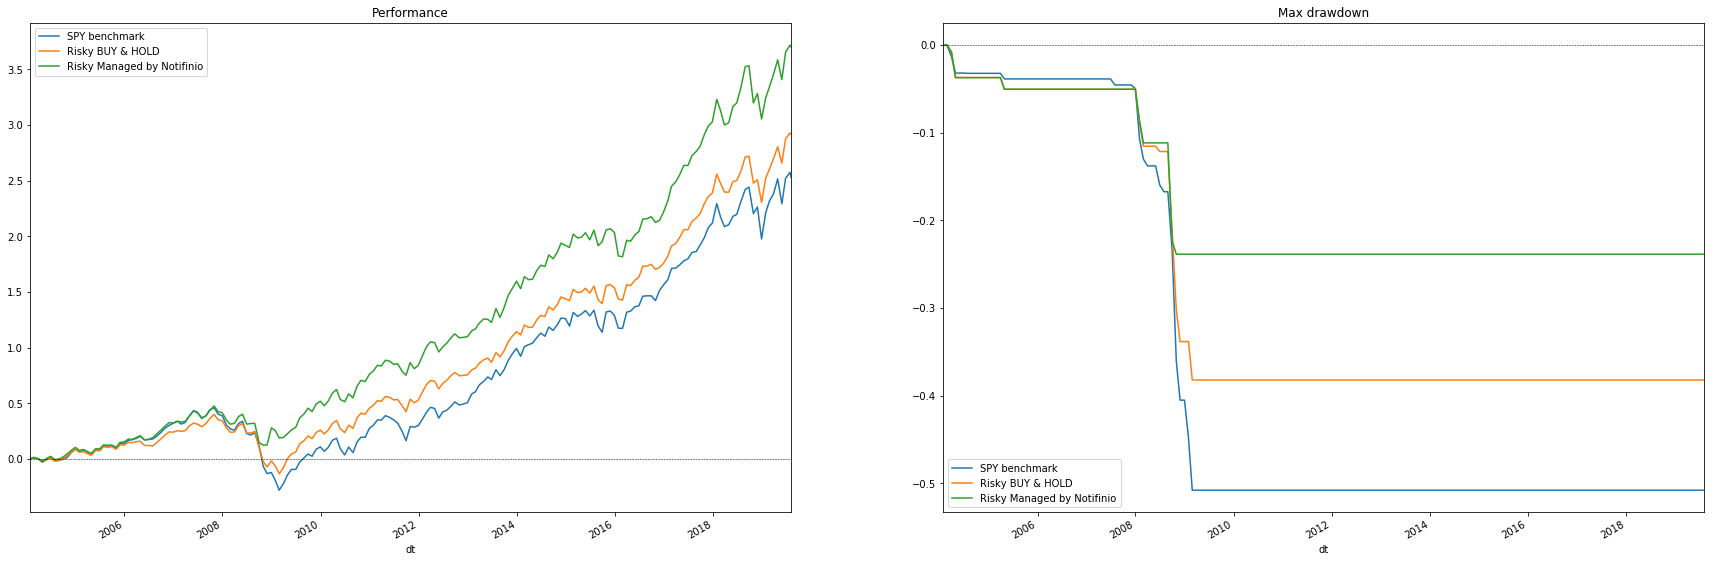

,performance,drawdown,annual return,sharpe
Risky Managed by Notifinio,370.002715,-23.858439,10.477376,0.916058
Risky BUY & HOLD,291.451096,-38.208951,9.184174,0.778661
SPY benchmark,252.845888,-50.784838,8.456704,0.602311


In [87]:
backtest(risky,save_results_path)

##2. Balanced Portfolio

Total:  3


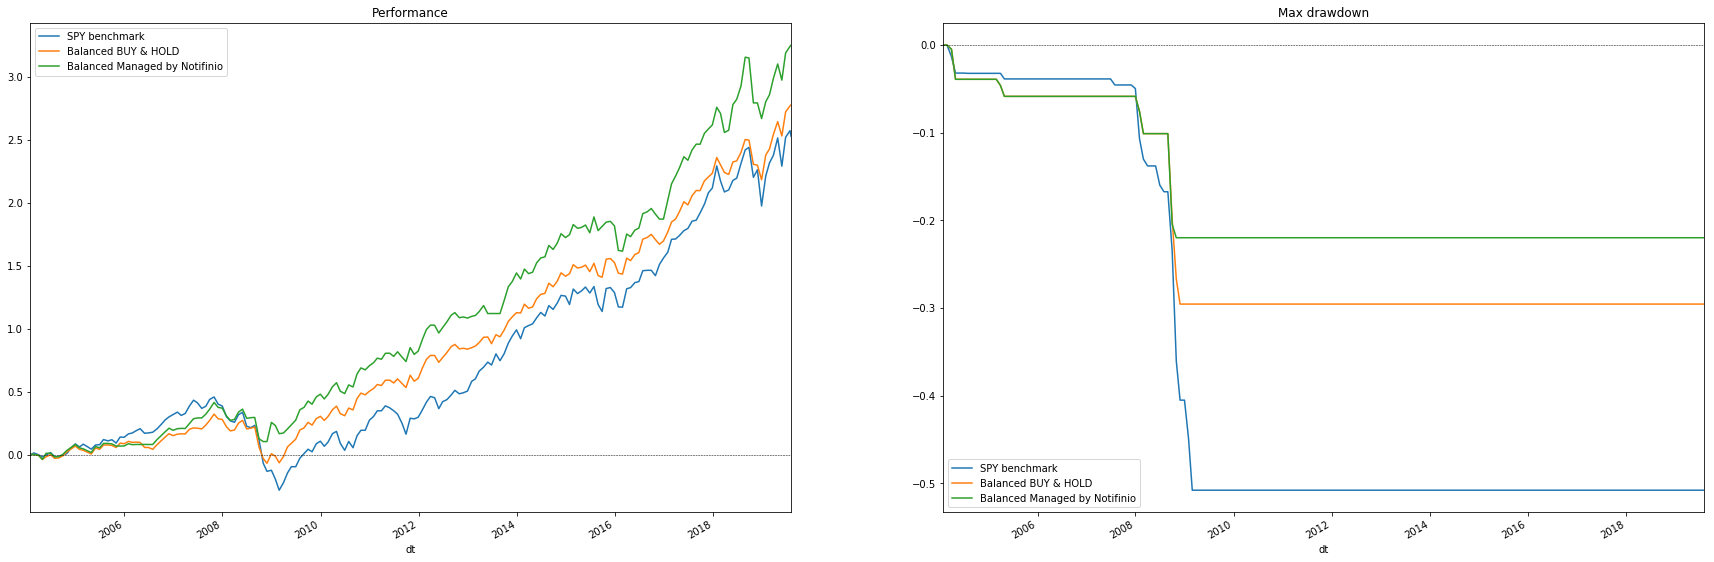

,performance,drawdown,annual return,sharpe
Balanced Managed by Notifinio,325.367102,-21.978849,9.769863,0.884942
Balanced BUY & HOLD,277.921668,-29.548547,8.937188,0.831755
SPY benchmark,252.845888,-50.784838,8.456704,0.602311


In [89]:
backtest(balanced,save_results_path)

##3. Conservative Portfolio

Total:  3


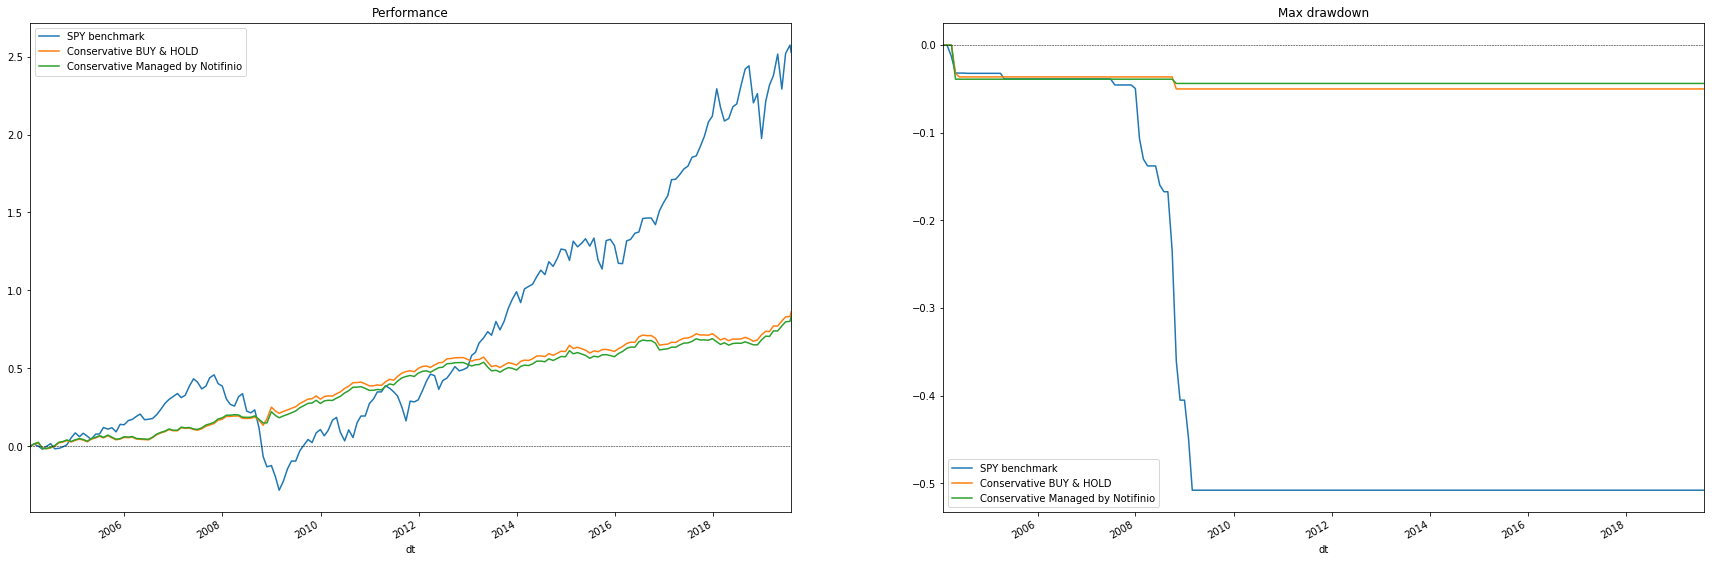

,performance,drawdown,annual return,sharpe
SPY benchmark,252.845888,-50.784838,8.456704,0.602311
Conservative BUY & HOLD,86.253227,-5.002915,4.085612,0.829302
Conservative Managed by Notifinio,83.058624,-4.375169,3.969735,0.820446


In [90]:
backtest(conservative,save_results_path)